In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import mutual_info_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFE, SelectFromModel
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler

# Input data files are available in the "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/data_description.txt
/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/train.csv
/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/sample_submission.csv
/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/test.csv


### Import data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/train.csv')
# Cleanup data
MSSubClassMap = {20: "1S_1946+",
                 30: "1S_1945-",
                 40: "1S_WA",
                 45: "1.5S_U",
                 50: "1.5S_F",
                 60: "2S_1946+",
                 70: "2S_1945-",
                 75: "2.5S",
                 80: "Split_Multi",
                 85: "Split_Foyer",
                 90: "Duplex",
                 120: "1S_PUD_1946+",
                 150: "1.5S_PUD",
                 160: "2S_PUD_1946+",
                 180: "PUD_Multi",
                 190: "2_Fam_Conv"}
df["MSSubClass"] = df["MSSubClass"].map(MSSubClassMap)
df['PoolQC'].fillna(value = 'None',inplace = True)
df['MiscFeature'].fillna(value = 'None',inplace = True)
df['Alley'].fillna(value = 'None',inplace = True)
df['Fence'].fillna(value = 'None',inplace = True)
df['FireplaceQu'].fillna(value = 'None',inplace = True)
df['GarageQual'].fillna(value = 'None',inplace = True)
df['BsmtQual'].fillna(value = 'None',inplace = True)
df['LotFrontage'].fillna(value = 0,inplace = True)
df = df[df['Electrical'].notna()]
df = df[df['MasVnrType'].notna()]

index1 = df[(df['BsmtExposure'].isna()) & (df['BsmtCond'].notna())].index
index2 = df[(df['BsmtFinType2'].isna()) & (df['BsmtCond'].notna())].index
df.drop(index = index1,axis=0,inplace=True)
df.drop(index = index2,axis=0,inplace=True)
df.drop(['GarageYrBlt'], axis=1, inplace=True)

#Seperate sales price column
df_SalePrice = df['SalePrice']
#drop id and sales price column from main dataframe
df.drop(["Id"], 1, inplace=True)
df.drop(['SalePrice'], axis=1, inplace=True)

# Merge dummies
def dummy_and_merge(new_col, old_cols):
  dummies = None
  for old_col in old_cols:
    if dummies is None:
      dummies = pd.get_dummies(df[old_col], prefix=new_col)
    else:                      
      dummies = dummies.add(pd.get_dummies(df[old_col], prefix=new_col), fill_value=0).astype(int)#.clip(0, 1)
  return dummies

condition_dummies = dummy_and_merge('Condition', ['Condition1', 'Condition2'])
df.drop(labels=['Condition1', 'Condition2'], axis=1, inplace=True)
exterior_dummies = dummy_and_merge('Exterior', ['Exterior1st', 'Exterior2nd'])
df.drop(labels=['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)
# Make dummy values
df_dummies = pd.get_dummies(df)
df_dummies = df_dummies.join(condition_dummies)
df_dummies = df_dummies.join(exterior_dummies)
# Display
pd.set_option('display.max_columns', None)
df_dummies.describe()
df_SalePrice.describe()
#condition_dummies.describe()
#df = pd.get_dummies(df, columns=df.select_dtypes(exclude='number').columns.tolist(), dummy_na = True)
#df.isna().sum().sort_values().tail(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


count      1449.000000
mean     180544.563147
std       79319.721026
min       34900.000000
25%      129900.000000
50%      162000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

###Test Models

In [ ]:
def root_mean_squared_log_error(y_true, y_pred):
  try:
    return mean_squared_error(np.log(np.abs(y_true)), np.log(np.abs(y_pred)), squared=False)
  except:
    return 0

def rms_log_scorer(estimator, X, y):
  return root_mean_squared_log_error(estimator.predict(X), y)

In [ ]:
scalar = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(df_dummies, df_SalePrice, test_size=0.2, random_state=0)
X_train = scalar.fit_transform(X_train, y_train)
X_test = scalar.transform(X_test)

print(f'Linear Regression + Regularization for {len(X_train[0])} features:')

lassoEst = LassoCV(max_iter=10000)
lassoEst.fit(X_train,y_train)
lassoPredTrain = lassoEst.predict(X_train)
lassoPredTest = lassoEst.predict(X_test)

ridgeEst = RidgeCV(alphas=np.linspace(100, 1000, num=900, endpoint=False))
ridgeEst.fit(X_train,y_train)
ridgePredTrain = ridgeEst.predict(X_train)
ridgePredTest = ridgeEst.predict(X_test)

elasticEst = ElasticNetCV(l1_ratio=[.91, .95, .97, .99, .995, .999, 1], max_iter=10000)
elasticEst.fit(X_train,y_train)
elasticPredTrain = elasticEst.predict(X_train)
elasticPredTest = elasticEst.predict(X_test)

print(f'Lasso R^2 score: {lassoEst.score(X_test, y_test)}')
print(f"The root mean squared error when training using lasso (a={lassoEst.alpha_:0.2f}) is {root_mean_squared_log_error(y_train, lassoPredTrain):0.5f}")
print(f"When testing on the test data, the root mean squared error is {root_mean_squared_log_error(y_test, lassoPredTest):0.5f}\n")

print(f'Ridge R^2 score: {ridgeEst.score(X_test, y_test)}')
print(f"The root mean squared error when training using ridge (a={ridgeEst.alpha_:0.2f}) is {root_mean_squared_log_error(y_train, ridgePredTrain):0.5f}")
print(f"When testing on the test data, the root mean squared error is {root_mean_squared_log_error(y_test, ridgePredTest):0.5f}\n")

print(f'Elastic-Net R^2 score: {elasticEst.score(X_test, y_test)}')
print(f"The root mean squared error when training using elastic net (a={elasticEst.alpha_:0.2f},l1_ratio={elasticEst.l1_ratio_:0.3f}) is {root_mean_squared_log_error(y_train, elasticPredTrain):0.5f}")
print(f"When testing on the test data, the root mean squared error is {root_mean_squared_log_error(y_test, elasticPredTest):0.5f}\n")

# Extract feature selection from lasso estimator
selected_features = SelectFromModel(estimator=lassoEst)
#X_selected = selected_features.fit_transform(X, df_SalePrice)
X_train_selected = selected_features.fit_transform(X_train, y_train)
X_test_selected = selected_features.transform(X_test)
feature_names = selected_features.get_feature_names_out(df_dummies.columns)
feature_idxes = selected_features.get_support(True)

#print(f'The {len(feature_names)} selected features from lasso are:')
#for i in range(len(feature_names)):
#  print(f'{feature_names[i]}')
print(f'\nLinear Regression + Regularization for selected {len(feature_names)} features:')

lassoEst.fit(X_train_selected,y_train)
lassoPredTrainSelected = lassoEst.predict(X_train_selected)
lassoPredTestSelected = lassoEst.predict(X_test_selected)

ridgeEst.fit(X_train_selected,y_train)
ridgePredTrain = ridgeEst.predict(X_train_selected)
ridgePredTest = ridgeEst.predict(X_test_selected)

elasticEst.fit(X_train_selected,y_train)
elasticPredTrain = elasticEst.predict(X_train_selected)
elasticPredTest = elasticEst.predict(X_test_selected)

print(f'Lasso R^2 score: {lassoEst.score(X_test_selected, y_test)}')
print(f"The root mean squared error when training using lasso (a={lassoEst.alpha_:0.2f}) is {root_mean_squared_log_error(y_train, lassoPredTrainSelected):0.5f}")
print(f"When testing on the test data, the root mean squared error is {root_mean_squared_log_error(y_test, lassoPredTestSelected):0.5f}\n")

print(f'Ridge R^2 score: {ridgeEst.score(X_test_selected, y_test)}')
print(f"The root mean squared error when training using ridge (a={ridgeEst.alpha_:0.2f}) is {root_mean_squared_log_error(y_train, ridgePredTrain):0.5f}")
print(f"When testing on the test data, the root mean squared error is {root_mean_squared_log_error(y_test, ridgePredTest):0.5f}\n")

print(f'Elastic-Net R^2 score: {elasticEst.score(X_test_selected, y_test)}')
print(f"The root mean squared error when training using elastic net (a={elasticEst.alpha_:0.2f},l1_ratio={elasticEst.l1_ratio_:0.3f}) is {root_mean_squared_log_error(y_train, elasticPredTrain):0.5f}")
print(f"When testing on the test data, the root mean squared error is {root_mean_squared_log_error(y_test, elasticPredTest):0.5f}\n")

Linear Regression + Regularization for 288 features:
Lasso R^2 score: 0.9133263141785254
The root mean squared error when training using lasso (a=878.45) is 0.12253
When testing on the test data, the root mean squared error is 0.12600

Ridge R^2 score: 0.8988457844680847
The root mean squared error when training using ridge (a=667.00) is 0.11951
When testing on the test data, the root mean squared error is 0.12147

Elastic-Net R^2 score: 0.9049691207124719
The root mean squared error when training using elastic net (a=354.99,l1_ratio=0.999) is 0.11879
When testing on the test data, the root mean squared error is 0.11674


Linear Regression + Regularization for selected 88 features:
Lasso R^2 score: 0.9163853759847761
The root mean squared error when training using lasso (a=287.65) is 0.12207
When testing on the test data, the root mean squared error is 0.12738

Ridge R^2 score: 0.9119922712849827
The root mean squared error when training using ridge (a=351.00) is 0.12133
When testing o

Text(0.5, 1.0, 'Ridge Prediction (Selected 88 Features)')

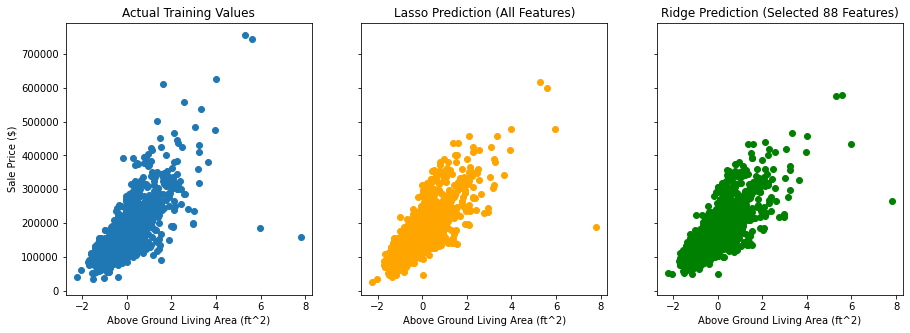

In [ ]:
idx = "GrLivArea"
idx = df_dummies.columns.get_loc(idx)
X_train_decoded = X_train

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15,5))

ax1.scatter(X_train_decoded[:,idx], y_train)
ax1.set_ylabel('Sale Price ($)')
ax1.set_xlabel('Above Ground Living Area (ft^2)')
ax1.set_title('Training Labels')

ax2.scatter(X_train_decoded[:,idx], lassoPredTrain, color='orange')
ax2.set_xlabel('Above Ground Living Area (ft^2)')
ax2.set_title('Lasso Prediction (All Features)')

ax3.scatter(X_train_decoded[:,idx], ridgePredTrain, color='green')
ax3.set_xlabel('Above Ground Living Area (ft^2)')
ax3.set_title(f'Ridge Prediction (Selected {len(feature_names)} Features)')

Text(0.5, 1.0, 'Ridge Prediction (Selected 64 Features)')

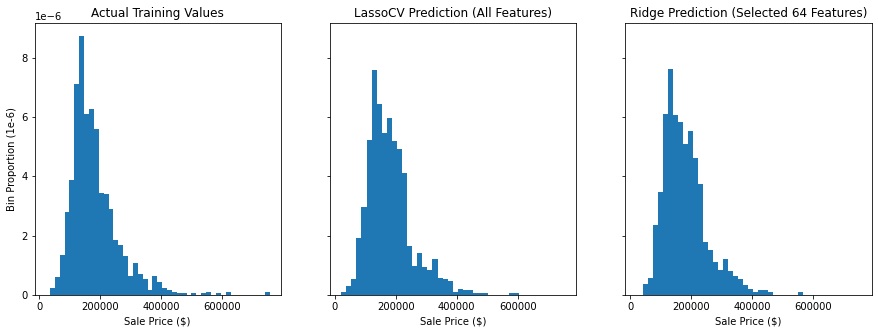

In [ ]:
def plot_hist(X, ax):
  IQR = np.quantile(X, 0.75) - np.quantile(X, 0.25)
  bin_width = 2 * IQR * pow(X.count(), -1/3)  # Use Freedman and Diaconis’ rule to find bin width
  bins = int((X.max() - X.min())/bin_width)
  X.plot.hist(bins=bins, density=1, ax=ax) 

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15,5))

plot_hist(y_train, ax1)
ax1.set_ylabel('Bin Proportion (1e-6)')
ax1.set_xlabel('Sale Price ($)')
ax1.set_title('Actual Training Values')

plot_hist(pd.Series(lassoPredTrain), ax2)
ax2.set_xlabel('Sale Price ($)')
ax2.set_title('LassoCV Prediction (All Features)')

plot_hist(pd.Series(ridgePredTrain), ax3)
ax3.set_xlabel('Sale Price ($)')
ax3.set_title(f'Ridge Prediction (Selected {len(feature_names)} Features)')

[0.91, 0.95, 0.97, 0.99, 0.995, 0.999, 1]
[68.95422038 66.05088479 64.68901087 63.38216217 63.06365884 62.8111517
 62.74834055]


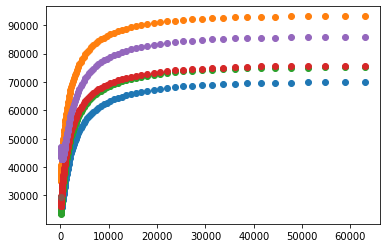

In [ ]:
# Plot the mean root square error as a function of the alphas for elasticEst
print(elasticEst.l1_ratio)
print(np.min(elasticEst.alphas_, axis=1))
alphas = np.reshape(elasticEst.alphas_[-3], (-1))
for i in range(5):
  mses = np.reshape(elasticEst.mse_path_[-3,:,i], (-1))
  plt.scatter(alphas, np.sqrt(mses))
plt.scatter(elasticEst.alpha_, np.sqrt(mean_squared_error(y_test, elasticPredTest)))

### Overview

In [ ]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2S_1946+,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,CompShg,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal
1,1S_1946+,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,1Fam,1Story,6,8,1976,1976,Gable,CompShg,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal
2,2S_1946+,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,CompShg,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal
3,2S_1945-,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,CompShg,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml
4,2S_1946+,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,CompShg,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal


In [ ]:
df.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1455,1456,2S_1946+,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,None,None,None,0,8,2007,WD,Normal
1456,1457,1S_1946+,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,None,MnPrv,None,0,2,2010,WD,Normal
1457,1458,2S_1945-,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,None,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,1S_1946+,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,None,Attchd,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,None,None,None,0,4,2010,WD,Normal
1459,1460,1S_1946+,RL,75.0,9937,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,None,Attchd,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,None,None,None,0,6,2008,WD,Normal


In [ ]:
df.describe(include="all")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1449.000000,1449,1449,1449.000000,1449.000000,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449.000000,1449.000000,1449.000000,1449.000000,1449,1449,1449,1449,1449,1449.000000,1449,1449,1449,1449,1412,1412,1412,1449.000000,1412,1449.000000,1449.000000,1449.000000,1449,1449,1449,1449,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449,1449.000000,1449,1449.000000,1449,1368,1368,1449.000000,1449.000000,1449,1368,1449,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449,1449,1449,1449.000000,1449.000000,1449.000000,1449,1449
unique,NaN,15,5,NaN,NaN,2,3,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,5,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,6,6,3,NaN,NaN,6,5,3,NaN,NaN,NaN,NaN,NaN,NaN,4,5,5,NaN,NaN,NaN,9,6
top,NaN,1S_1946+,RL,NaN,NaN,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,None,Attchd,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN,WD,Normal
freq,NaN,531,1143,NaN,NaN,1443,1359,918,1300,1448,1043,1371,225,1249,1434,1210,720,NaN,NaN,NaN,NaN,1131,1423,507,496,863,NaN,905,1271,636,648,1301,944,426,NaN,1246,NaN,NaN,NaN,1417,732,1354,1324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734,NaN,1350,NaN,685,861,605,NaN,NaN,1300,1315,1329,NaN,NaN,NaN,NaN,NaN,NaN,1442,1168,1395,NaN,NaN,NaN,1259,1191
mean,729.496204,NaN,NaN,57.600414,10505.292616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.091787,5.580400,1971.048999,1984.734990,NaN,NaN,NaN,NaN,NaN,103.596273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,442.109731,NaN,46.572119,566.227743,1054.909593,NaN,NaN,NaN,NaN,1161.384403,346.641132,5.888889,1513.914424,0.423741,0.057971,1.561767,0.380952,2.866805,1.046239,NaN,6.516218,NaN,0.612146,NaN,NaN,NaN,1.763975,472.242926,NaN,NaN,NaN,94.443754,46.420290,21.982747,3.435473,15.175293,2.779848,NaN,NaN,NaN,43.819186,6.319531,2007.815735,NaN,NaN
std,421.860946,NaN,NaN,34.671721,9999.462295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.381306,1.113976,30.188514,20.654422,NaN,NaN,NaN,NaN,NaN,181.159595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455.182945,NaN,161.485248,441.569073,434.546553,NaN,NaN,NaN,NaN,385.026776,436.467071,48.804741,526.108808,0.518859,0.239605,0.550440,0.502559,0.815633,0.219715,NaN,1.627600,NaN,0.643726,NaN,NaN,NaN,0.748516,214.051742,NaN,NaN,NaN,125.492157,66.081656,61.144960,29.426965,55.953287,40.328903,NaN,NaN,NaN,497.989369,2.698099,1.329074,NaN,NaN
min,1.000000,NaN,NaN,0.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,Na

### Basic Information

Columns with null values

In [ ]:
df.isna().sum().sort_values().tail(20)

SaleCondition     0
YearRemodAdd      0
BsmtUnfSF         0
BsmtFinSF2        0
BsmtFinSF1        0
Foundation        0
ExterCond         0
BsmtQual          0
MasVnrArea        0
MasVnrType        0
RoofMatl          0
RoofStyle         0
ExterQual         0
BsmtCond         37
BsmtExposure     37
BsmtFinType1     37
BsmtFinType2     37
GarageType       81
GarageCond       81
GarageFinish     81
dtype: int64

histogram of sales prices

bin width: 14864.028509582715
# of bins: 48

Plotting Normalized Density of Sale Prices (area of bins = 1):


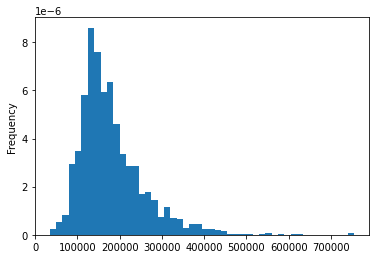

In [ ]:
IQR = np.quantile(df_SalePrice, 0.75) - np.quantile(df_SalePrice, 0.25)
bin_width = 2 * IQR * pow(df_SalePrice.count(), -1/3)  # Use Freedman and Diaconis’ rule to find bin width
print(f'bin width: {bin_width}')

bins = int((df_SalePrice.max() - df_SalePrice.min())/bin_width)
print(f'# of bins: {bins}')

df_SalePrice.plot.hist(bins=bins, density=1)

print('\nPlotting Normalized Density of Sale Prices (area of bins = 1):')

###Numerical Data

In [ ]:
numDf =  df.select_dtypes(include='number').copy()
#numDf["LivArea"] = numDf["GrLivArea"].add(numDf["TotalBsmtSF"])
#numDf["IndoorArea"] = numDf["LivArea"].add(numDf["GarageArea"])
numDf.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008


correlation matrix

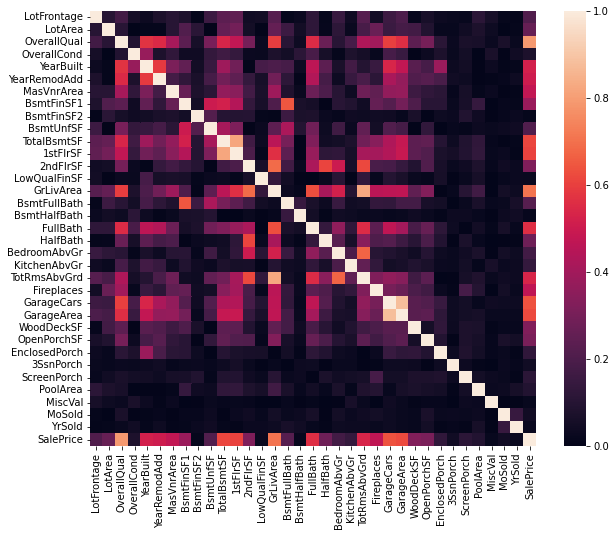

In [ ]:
corrMatrix = numDf.join(df_SalePrice).corr().abs()
plt.figure(figsize=(10,8))
f = sn.heatmap(corrMatrix, vmin=0, vmax=1, xticklabels=True, yticklabels=True)
plt.show()

highest correlations

In [ ]:
sortedCorrMatrix = corrMatrix.iloc[(-corrMatrix.SalePrice).argsort()]
sortedCorrMatrix["SalePrice"]

SalePrice        1.000000
OverallQual      0.789881
GrLivArea        0.710319
GarageCars       0.639235
GarageArea       0.621918
TotalBsmtSF      0.614420
1stFlrSF         0.606678
FullBath         0.562492
TotRmsAbvGrd     0.536419
YearBuilt        0.522918
YearRemodAdd     0.507138
MasVnrArea       0.476985
Fireplaces       0.468764
BsmtFinSF1       0.383398
WoodDeckSF       0.325569
2ndFlrSF         0.323842
OpenPorchSF      0.312097
HalfBath         0.283257
LotArea          0.264787
BsmtFullBath     0.224354
BsmtUnfSF        0.214098
LotFrontage      0.207892
BedroomAbvGr     0.171898
KitchenAbvGr     0.137321
EnclosedPorch    0.128553
ScreenPorch      0.113362
PoolArea         0.093227
OverallCond      0.075898
3SsnPorch        0.045379
MoSold           0.044118
YrSold           0.026865
LowQualFinSF     0.025171
MiscVal          0.020885
BsmtHalfBath     0.015788
BsmtFinSF2       0.012762
Name: SalePrice, dtype: float64

Apply filtering to eliminate low corrs with SalePrice and reduce vars with high corrs with eachother

In [ ]:
LOW_CORRELATION_BOUND = 0.5
sortedCorrMatrix = corrMatrix.iloc[(-corrMatrix.SalePrice).argsort()]
sortedCorrMatrix = sortedCorrMatrix[sortedCorrMatrix["SalePrice"] > LOW_CORRELATION_BOUND].T[sortedCorrMatrix["SalePrice"] > LOW_CORRELATION_BOUND].T
sortedCorrMatrix = sortedCorrMatrix.drop("SalePrice", axis=0)
sortedTargetCorrs = sortedCorrMatrix["SalePrice"]
sortedCorrMatrix = sortedCorrMatrix.drop("SalePrice", axis=1)
#sortedTargetCorrs

HIGH_CORRELATION_BOUND = 0.9
#(sortedCorrMatrix.drop("SalePrice", axis=1).max(1, ) > HIGH_CORRELATION_BOUND)
crossCorrs = sortedCorrMatrix.unstack().sort_values(ascending = False)
crossCorrs = crossCorrs[crossCorrs < 1][crossCorrs > HIGH_CORRELATION_BOUND].drop_duplicates()

for idx, item in crossCorrs.items():
  if (sortedTargetCorrs.index.isin([idx[0]]) == False).all() or (sortedTargetCorrs.index.isin([idx[1]]) == False).all():
    continue
  if sortedTargetCorrs[idx[0]] > sortedTargetCorrs[idx[1]]:
    sortedTargetCorrs = sortedTargetCorrs.drop(idx[1])
  else:
    sortedTargetCorrs = sortedTargetCorrs.drop(idx[0])
sortedTargetCorrs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


OverallQual     0.789881
GrLivArea       0.710319
GarageCars      0.639235
GarageArea      0.621918
TotalBsmtSF     0.614420
1stFlrSF        0.606678
FullBath        0.562492
TotRmsAbvGrd    0.536419
YearBuilt       0.522918
YearRemodAdd    0.507138
Name: SalePrice, dtype: float64

###Catagorical Data

In [ ]:
catDf = df.select_dtypes(exclude='number').copy()
catDf = catDf.join(df_SalePrice.copy())
catDf.describe()

,SalePrice
count,1449.000000
mean,180544.563147
std,79319.721026
min,34900.000000
25%,129900.000000
50%,162000.000000
75%,214000.000000
max,755000.000000


In [ ]:
catDf = pd.get_dummies(catDf)
catDf

,SalePrice,MSSubClass_1.5S_F,MSSubClass_1.5S_U,MSSubClass_1S_1945-,MSSubClass_1S_1946+,MSSubClass_1S_PUD_1946+,MSSubClass_1S_WA,MSSubClass_2.5S,MSSubClass_2S_1945-,MSSubClass_2S_1946+,MSSubClass_2S_PUD_1946+,MSSubClass_2_Fam_Conv,MSSubClass_Duplex,MSSubClass_PUD_Multi,MSSubClass_Split_Foyer,MSSubClass_Split_Multi,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_E

In [ ]:
mutualScoreMatrix = catDf.corr(method=mutual_info_score)
mutualScoreMatrix

KeyboardInterrupt: ignored